In [11]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.optim import Adam
from tqdm import tqdm
import torch.nn.functional as F
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np
from torch import nn
import math
import os
import PIL
from PIL import Image

IMAGE_FOLDER = "./downloadedskins"
IMAGE_SHAPE = (64, 64, 4)
IMAGE_SIZE = 64
BATCH_SIZE = 128

T = 300

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

# Enable a bunch of optimizations
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True


In [12]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

@torch.no_grad()
def forward_diffusion_sample(x_0, t):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    
    noise = torch.randn_like(x_0) # sample noise from standard normal distribution
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)

    # mean + variance
    final_image = sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
    final_image = torch.clamp(final_image, -1., 1.)
    
    return final_image, noise.to(device)

    


# Define beta schedule
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [13]:
def load_transformed_dataset():
    transform = transforms.Compose([
        transforms.Lambda(lambda img: img.convert("RGBA")),
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: t * 2. - 1.), # Normalize to [-1, 1]
    ])

    dataset = torchvision.datasets.ImageFolder(root=IMAGE_FOLDER, transform=transform)
    return dataset
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1.) / 2.),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print(data[0][0].shape)

torch.Size([4, 64, 64])


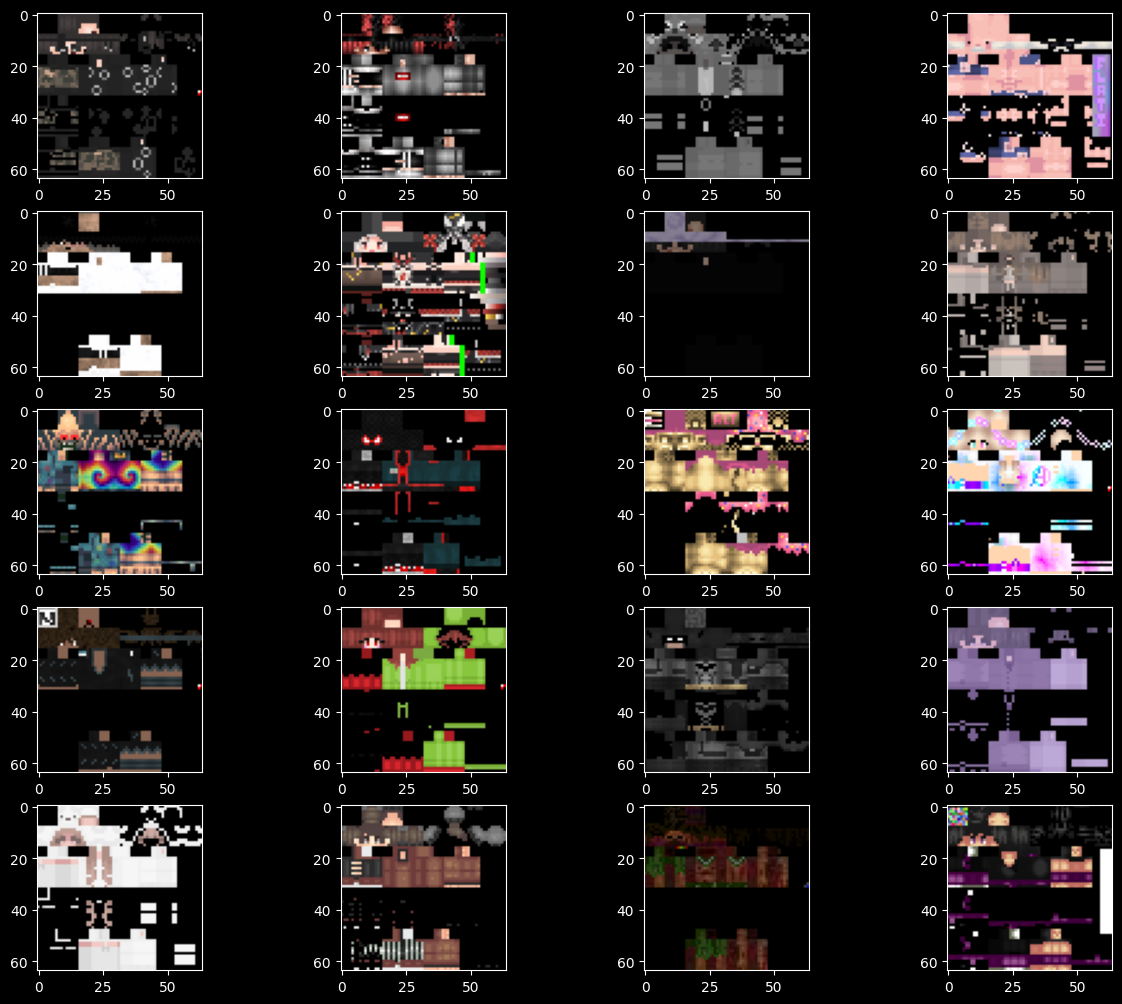

In [30]:
def show_images(dataset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        show_tensor_image(img[0])

# Show some images
show_images(data)

image.shape:  torch.Size([4, 64, 64])


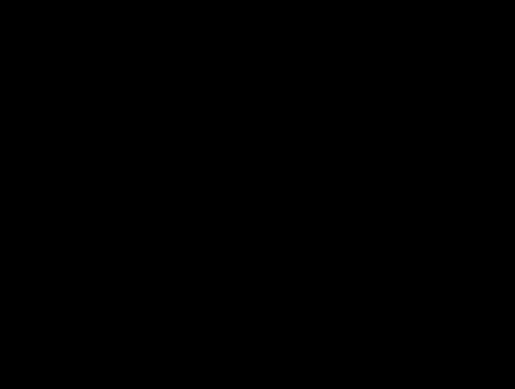

Epoch 0 | Loss: 0.5429:   2%|          | 2048/88192 [00:17<04:56, 290.16it/s]

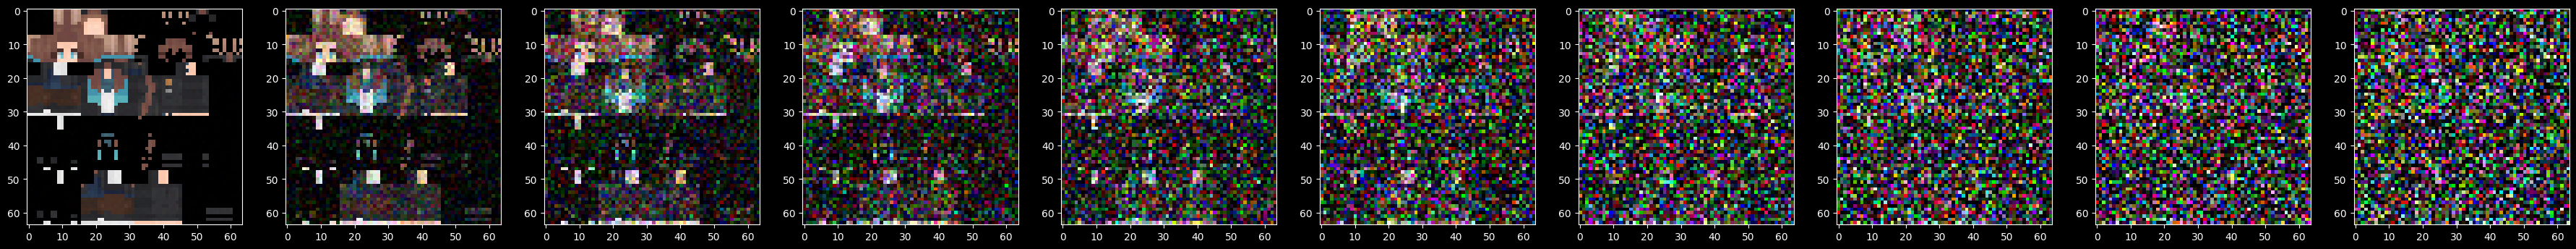

In [23]:
# Simulate forward diffusion
image = next(iter(dataloader))[0][0]
print("image.shape: ", image.shape)
plt.axis('off')

plt.figure(figsize=(50,50))
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

In [16]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)
    
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings
    
class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 4
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 4 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [17]:
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62439524


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

In [18]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [19]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMAGE_SIZE
    img = torch.randn((1, 4, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu()[0])
    plt.show()            

In [20]:
# TRAIN MODEL
print("Using device: {}".format(device))
model.to(device)

optimizer = Adam(model.parameters(), lr=0.001)
epochs = 500

pbar_epochs = tqdm(total=epochs, desc="Epochs", leave=True, position=0)
pbar_epochs.update(0)
print("Training...")
for epoch in range(epochs):
  print("Beginning epoch {}".format(epoch))
  pbar_epochs.update(1)
  pbar_batches = tqdm(total=len(dataloader) * BATCH_SIZE, desc=f"Epoch {epoch} | Loss: N/A", leave=True, ascii=" >=", position=0) #  ⠄⠤⠦⠶⠷⠿
  
  for step, batch in enumerate(dataloader):
    optimizer.zero_grad()

    t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
    loss = get_loss(model, batch[0], t)
    loss.backward()
    optimizer.step()

    pbar_batches.set_description(f"Epoch {epoch} | Loss: {loss.item():.4f}")

    pbar_batches.update(BATCH_SIZE)
  pbar_batches.close()

  # Save the model after each epoch
  torch.save(model.state_dict(), f"The_La_Grande_Jatte/The_La_Grande_Jatte-{epoch}.pt")
  sample_plot_image()

pbar_epochs.close()

Using device: cuda


Epochs:   0%|          | 1/500 [2:14:39<1119:53:04, 8079.33s/it]


Training...
Beginning epoch 0


Epoch 0 | Loss: 0.3166:  25%|==        | 22016/88192 [2:14:39<6:44:44,  2.72it/s]
Epoch 0 | Loss: 0.5429:   2%|          | 2048/88192 [00:07<04:56, 290.16it/s]

KeyboardInterrupt: 

In [ ]:
# USE MODEL

# Prompt the user for an image path and interaction number
image_path = input("Enter the image path: ") or "./EnderLordWizard.png"
interaction_number = int(input("Enter the interaction number: ")) or 100

plt.figure(figsize=(150,150))
plt.axis('off')
plt.subplot(1, 103, 1)
plt.imshow(Image.open(image_path))

sample_plot_image()

# Load the image and convert it to a tensor
# img = Image.open(image_path)
# img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
# img = np.array(img)
# img = img / 127.5 - 1.0
# img = torch.tensor(img, dtype=torch.float32)
# img = img.permute(2, 0, 1)
# img = img.unsqueeze(0)
# img = img.to(device)

# # Sample the image
# img, noise = forward_diffusion_sample(img, torch.Tensor([interaction_number]).type(torch.int64))

# # Plot the image
# plt.subplot(1, 103, 2)
# show_tensor_image(img.detach().cpu()[0])

# for i in range(interaction_number, 0, -1):
#     img = sample_timestep(img, torch.full((1,), i, device=device, dtype=torch.long))
#     img = torch.clamp(img, -1.0, 1.0)
#     plt.subplot(1, 103, interaction_number - i + 3)
#     show_tensor_image(img.detach().cpu()[0])

# # Plot the image
# plt.subplot(1, 103, 103)
# show_tensor_image(img.detach().cpu()[0])

# plt.show()
